# CUDA CV-DV Hybrid Quantum Simulation Test

Clean test suite for the CUDA library simulating continuous-variable discrete-variable (CV-DV) hybrid quantum systems.

In [1]:
# Imports
import numpy as np
import ctypes
from ctypes import c_int, c_double, POINTER
import matplotlib.pyplot as plt
import scienceplots
import subprocess
import os
from numpy import pi, sqrt

# Matplotlib configuration
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 18, 'text.usetex': True})

In [2]:
# Simulation parameters
DV_LEVEL = 0       # Number of qubits (0 = no qubits, CV mode only)
CV_LEVEL = 12      # Position grid resolution: 2^CV_LEVEL points
WIGNER_N = 201     # Wigner function grid size (NxN)
WIGNER_MAX = 5.0   # Wigner function range: [-WIGNER_MAX, WIGNER_MAX]
PLOT_X_RANGE = 6   # x-axis range for wavefunction plots

In [3]:
# Compile and load CUDA library
project_dir = os.path.dirname(os.path.abspath('__file__'))
build_dir = os.path.join(project_dir, 'build')

# Compile
result = subprocess.run(
    ['bash', os.path.join(project_dir, 'run.sh')],
    capture_output=True, text=True
)
print(result.stdout)
if result.returncode != 0:
    print(result.stderr)
    raise RuntimeError('Build failed')

# Load library
lib_path = os.path.join(build_dir, 'libcvdv.so')
lib = ctypes.CDLL(lib_path)

# Define C function signatures
# int cvdv_init(int dv_level, int cv_level)
lib.cvdv_init.argtypes = [c_int, c_int]
lib.cvdv_init.restype = c_int

# void cvdv_free()
lib.cvdv_free.argtypes = []
lib.cvdv_free.restype = None

# void cvdv_set_coherent(double alpha_re, double alpha_im)
lib.cvdv_set_coherent.argtypes = [c_double, c_double]
lib.cvdv_set_coherent.restype = None

# void cvdv_set_fock(int n)
lib.cvdv_set_fock.argtypes = [c_int]
lib.cvdv_set_fock.restype = None

# void cvdv_displacement(double beta_re, double beta_im)
lib.cvdv_displacement.argtypes = [c_double, c_double]
lib.cvdv_displacement.restype = None

# void cvdv_cd(double alpha_re, double alpha_im, int ctrl_qubit)
lib.cvdv_cd.argtypes = [c_double, c_double, c_int]
lib.cvdv_cd.restype = None

# void cvdv_pauli_rotation(int target_qubit, int axis, double theta)
lib.cvdv_pauli_rotation.argtypes = [c_int, c_int, c_double]
lib.cvdv_pauli_rotation.restype = None

# void cvdv_hadamard(int target_qubit)
lib.cvdv_hadamard.argtypes = [c_int]
lib.cvdv_hadamard.restype = None

# void cvdv_get_wigner(double* wigner_out, int wigner_n, double w_x_max, double w_p_max)
lib.cvdv_get_wigner.argtypes = [POINTER(c_double), c_int, c_double, c_double]
lib.cvdv_get_wigner.restype = None

# void cvdv_get_wigner_single_slice(double* wigner_out, int slice_idx, int wigner_n, double w_x_max, double w_p_max)
lib.cvdv_get_wigner_single_slice.argtypes = [POINTER(c_double), c_int, c_int, c_double, c_double]
lib.cvdv_get_wigner_single_slice.restype = None

# void cvdv_get_state(double* real_out, double* imag_out)
lib.cvdv_get_state.argtypes = [POINTER(c_double), POINTER(c_double)]
lib.cvdv_get_state.restype = None

# int cvdv_get_dv_level()
lib.cvdv_get_dv_level.argtypes = []
lib.cvdv_get_dv_level.restype = c_int

# int cvdv_get_dv_dim()
lib.cvdv_get_dv_dim.argtypes = []
lib.cvdv_get_dv_dim.restype = c_int

# int cvdv_get_cv_level()
lib.cvdv_get_cv_level.argtypes = []
lib.cvdv_get_cv_level.restype = c_int

# int cvdv_get_cv_dim()
lib.cvdv_get_cv_dim.argtypes = []
lib.cvdv_get_cv_dim.restype = c_int

# double cvdv_get_dx()
lib.cvdv_get_dx.argtypes = []
lib.cvdv_get_dx.restype = c_double

# void cvdv_get_dv_probs(double* probs_out)
lib.cvdv_get_dv_probs.argtypes = [POINTER(c_double)]
lib.cvdv_get_dv_probs.restype = None

print("Library compiled and loaded successfully!")

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/luxi/cuda-cvdv/build
[100%] Built target cvdv
Build successful: /home/luxi/cuda-cvdv/build/libcvdv.so

Library compiled and loaded successfully!


In [4]:
# CVDV Python wrapper class
class CVDV:
    """Python wrapper for CUDA CV-DV quantum simulator."""
    
    def __init__(self, dv_level: int = 0, cv_level: int = 10):
        """Initialize simulator with dv_level qubits and 2^cv_level grid points."""
        lib.cvdv_init(dv_level, cv_level)
        self.dv_level = lib.cvdv_get_dv_level()
        self.dv_dim = lib.cvdv_get_dv_dim()
        self.cv_level = lib.cvdv_get_cv_level()
        self.cv_dim = lib.cvdv_get_cv_dim()
        self.dx = lib.cvdv_get_dx()
    
    def __del__(self):
        """Free CUDA resources."""
        try:
            lib.cvdv_free()
        except:
            pass
    
    def set_coherent(self, alpha_re, alpha_im):
        lib.cvdv_set_coherent(alpha_re, alpha_im)
    
    def set_fock(self, n: int):
        """Set state to Fock state |n>."""
        lib.cvdv_set_fock(n)
    
    def displacement(self, beta):
        """Apply displacement operator D(β) to the bosonic mode."""
        if isinstance(beta, (int, float)):
            beta = complex(beta, 0.0)
        lib.cvdv_displacement(c_double(beta.real), c_double(beta.imag))
    
    def get_wigner(self, wigner_n: int = 101, w_x_max: float = 5.0, w_p_max: float = 5.0):
        """Compute Wigner function on a grid."""
        wigner = np.zeros(wigner_n * wigner_n, dtype=np.float64)
        lib.cvdv_get_wigner(
            wigner.ctypes.data_as(POINTER(c_double)),
            wigner_n, w_x_max, w_p_max
        )
        return wigner.reshape((wigner_n, wigner_n))
    
    def get_state(self):
        """Get full state vector as 2D array [qubit_idx, x_idx]."""
        total_size = self.dv_dim * self.cv_dim
        real_arr = np.zeros(total_size, dtype=np.float64)
        imag_arr = np.zeros(total_size, dtype=np.float64)
        lib.cvdv_get_state(
            real_arr.ctypes.data_as(POINTER(c_double)),
            imag_arr.ctypes.data_as(POINTER(c_double))
        )
        state = real_arr + 1j * imag_arr
        return state.reshape((self.dv_dim, self.cv_dim))
    
    def get_x_grid(self):
        """Get position grid points."""
        return (np.arange(self.cv_dim) - self.cv_dim // 2) * self.dx

print("CVDV class defined!")

CVDV class defined!


In [5]:
# Initialize with vacuum state
sim = CVDV(dv_level=DV_LEVEL, cv_level=CV_LEVEL)
sim.set_fock(0)

print(f"DV level: {sim.dv_level}, DV dim: {sim.dv_dim}")
print(f"CV level: {sim.cv_level}, CV dim: {sim.cv_dim}")
print(f"dx = {sim.dx:.6f}")
print(f"x range: [{-sim.cv_dim//2 * sim.dx:.2f}, {(sim.cv_dim//2 - 1) * sim.dx:.2f}]")

DV level: 0, DV dim: 1
CV level: 12, CV dim: 4096
dx = 0.039166
x range: [-80.21, 80.17]


Wavefunction norm (should be 1.0): 1.0000000000


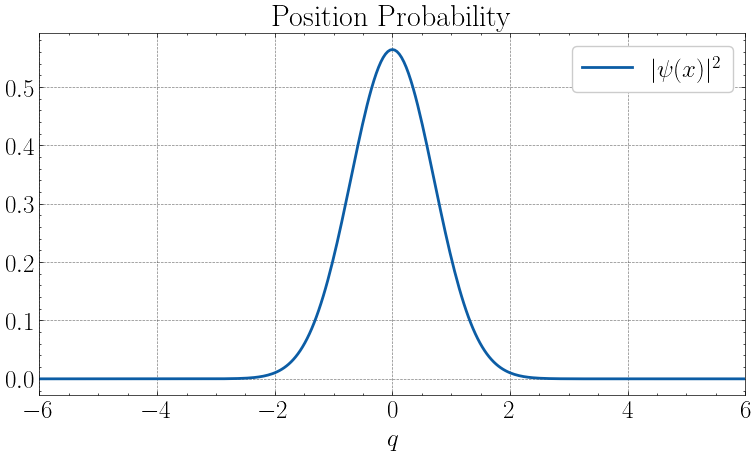

In [6]:
# Test wavefunction normalization and plot
state = sim.get_state()
x = sim.get_x_grid()

# Check normalization: ∫|ψ(x)|² dx = 1
psi_norm = np.sum(np.abs(state[0])**2) * sim.dx
print(f"Wavefunction norm (should be 1.0): {psi_norm:.10f}")

# Plot wavefunction
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, np.abs(state[0])**2, linewidth=2, label=r'$|\psi(x)|^2$')
ax.set_xlabel(r'$q$')
ax.set_title(f'Position Probability')
ax.set_xlim(-PLOT_X_RANGE, PLOT_X_RANGE)
ax.legend()
plt.tight_layout()
plt.show()

Wigner norm (should be 1.0): 1.0004199386
Purity (should be 1.0 for pure states): 1.0011730442


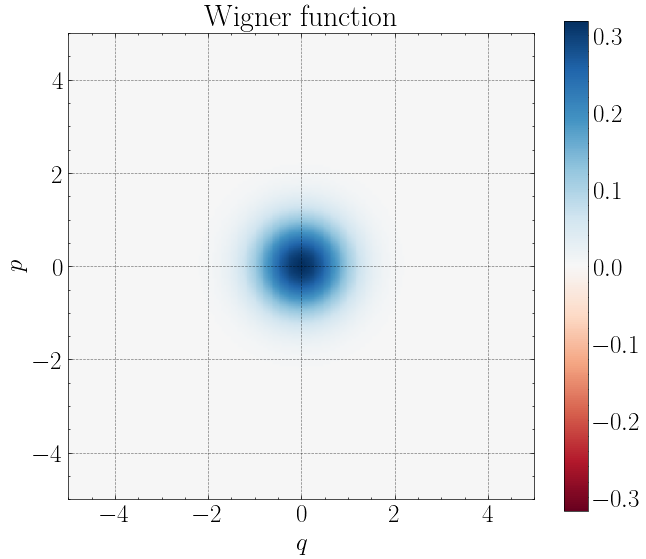

In [7]:
# Test Wigner function normalization and plot
wigner = sim.get_wigner(wigner_n=WIGNER_N, w_x_max=WIGNER_MAX, w_p_max=WIGNER_MAX)

# Check normalization: ∫∫W(x,p) dx dp = 1
w_dx = 2 * WIGNER_MAX / (WIGNER_N - 1)
w_dp = 2 * WIGNER_MAX / (WIGNER_N - 1)
wigner_norm = np.sum(wigner) * w_dx * w_dp
print(f"Wigner norm (should be 1.0): {wigner_norm:.10f}")

# Check purity: 2π∫∫W²(x,p) dx dp = 1 for pure states
wigner_square_integral = np.sum(wigner**2) * w_dx * w_dp
wigner_purity = 2 * np.pi * wigner_square_integral
print(f"Purity (should be 1.0 for pure states): {wigner_purity:.10f}")

# Plot Wigner function
fig, ax = plt.subplots(figsize=(7, 6))
vmax = np.max(np.abs(wigner))
im = ax.imshow(wigner, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX], 
               origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$p$')
ax.set_title(f'Wigner function')
cbar = plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Test Displacement Operator

Test the new efficient displacement implementation using phase multiplication.

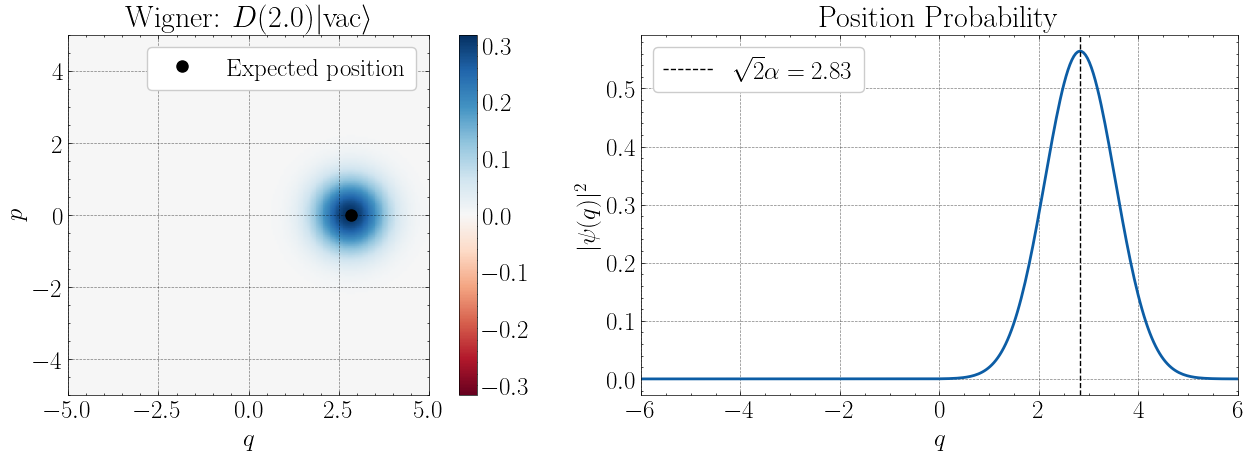

Wavefunction norm: 1.0000000000


In [8]:
# Test 1: Displace vacuum state with pure real displacement
sim_test = CVDV(dv_level=DV_LEVEL, cv_level=CV_LEVEL)
sim_test.set_fock(0)  # Start with vacuum

# Apply displacement with alpha = 2.0 (pure real)
alpha_test = 2.0
sim_test.displacement(alpha_test)

# Get Wigner function
wigner_test = sim_test.get_wigner(wigner_n=WIGNER_N, w_x_max=WIGNER_MAX, w_p_max=WIGNER_MAX)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Wigner function
vmax = np.max(np.abs(wigner_test))
im1 = ax1.imshow(wigner_test, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX], 
                 origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
ax1.set_xlabel(r'$q$')
ax1.set_ylabel(r'$p$')
ax1.set_title(rf'Wigner: $D({alpha_test})|\mathrm{{vac}}\rangle$')
ax1.plot(np.sqrt(2)*alpha_test, 0, 'ko', markersize=8, label='Expected position')
ax1.legend()
plt.colorbar(im1, ax=ax1)

# Wavefunction
state_test = sim_test.get_state()
x_test = sim_test.get_x_grid()
ax2.plot(x_test, np.abs(state_test[0])**2, linewidth=2)
ax2.axvline(np.sqrt(2)*alpha_test, color='k', linestyle='--', label=rf'$\sqrt{{2}}\alpha = {np.sqrt(2)*alpha_test:.2f}$')
ax2.set_xlabel(r'$q$')
ax2.set_ylabel(r'$|\psi(q)|^2$')
ax2.set_title('Position Probability')
ax2.set_xlim(-PLOT_X_RANGE, PLOT_X_RANGE)
ax2.legend()

plt.tight_layout()
plt.show()

# Check normalization
psi_norm = np.sum(np.abs(state_test[0])**2) * sim_test.dx
print(f"Wavefunction norm: {psi_norm:.10f}")

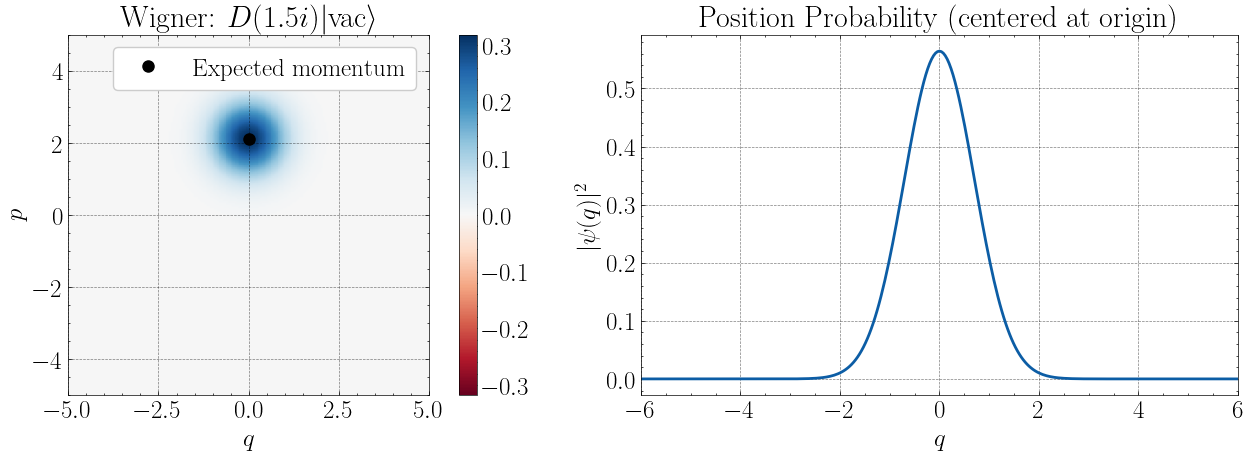

Wavefunction norm: 1.0000000000


In [9]:
# Test 2: Displace with pure imaginary displacement
sim_test2 = CVDV(dv_level=DV_LEVEL, cv_level=CV_LEVEL)
sim_test2.set_fock(0)  # Start with vacuum

# Apply displacement with alpha = 1.5i (pure imaginary)
alpha_test2 = 1.5j
sim_test2.displacement(alpha_test2)

# Get Wigner function
wigner_test2 = sim_test2.get_wigner(wigner_n=WIGNER_N, w_x_max=WIGNER_MAX, w_p_max=WIGNER_MAX)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Wigner function
vmax = np.max(np.abs(wigner_test2))
im1 = ax1.imshow(wigner_test2, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX], 
                 origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
ax1.set_xlabel(r'$q$')
ax1.set_ylabel(r'$p$')
ax1.set_title(rf'Wigner: $D({alpha_test2.imag}i)|\mathrm{{vac}}\rangle$')
ax1.plot(0, np.sqrt(2)*alpha_test2.imag, 'ko', markersize=8, label='Expected momentum')
ax1.legend()
plt.colorbar(im1, ax=ax1)

# Wavefunction
state_test2 = sim_test2.get_state()
x_test2 = sim_test2.get_x_grid()
ax2.plot(x_test2, np.abs(state_test2[0])**2, linewidth=2)
ax2.set_xlabel(r'$q$')
ax2.set_ylabel(r'$|\psi(q)|^2$')
ax2.set_title('Position Probability (centered at origin)')
ax2.set_xlim(-PLOT_X_RANGE, PLOT_X_RANGE)

plt.tight_layout()
plt.show()

# Check normalization
psi_norm2 = np.sum(np.abs(state_test2[0])**2) * sim_test2.dx
print(f"Wavefunction norm: {psi_norm2:.10f}")

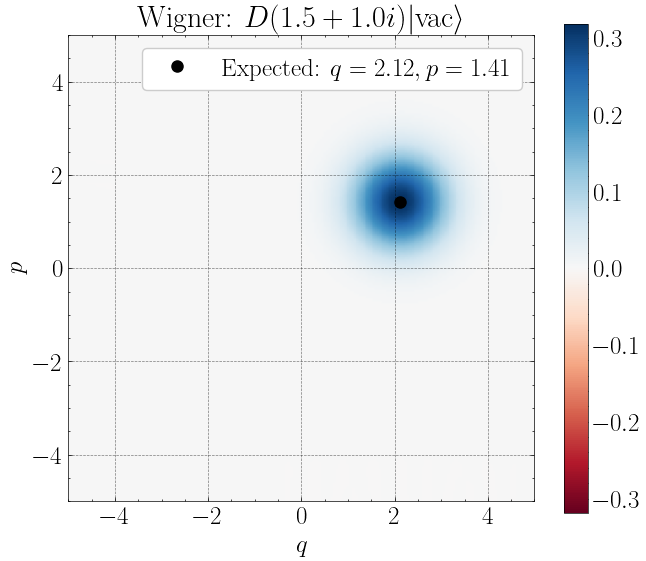

Wavefunction norm: 1.0000000000


In [10]:
# Test 3: General complex displacement
sim_test3 = CVDV(dv_level=DV_LEVEL, cv_level=CV_LEVEL)
sim_test3.set_fock(0)  # Start with vacuum

# Apply displacement with alpha = 1.5 + 1.0i
alpha_test3 = 1.5 + 1.0j
sim_test3.displacement(alpha_test3)

# Get Wigner function
wigner_test3 = sim_test3.get_wigner(wigner_n=WIGNER_N, w_x_max=WIGNER_MAX, w_p_max=WIGNER_MAX)

# Plot
fig, ax = plt.subplots(figsize=(7, 6))

# Wigner function
vmax = np.max(np.abs(wigner_test3))
im = ax.imshow(wigner_test3, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX], 
               origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$p$')
ax.set_title(rf'Wigner: $D({alpha_test3.real}+{alpha_test3.imag}i)|\mathrm{{vac}}\rangle$')
expected_q = np.sqrt(2) * alpha_test3.real
expected_p = np.sqrt(2) * alpha_test3.imag
ax.plot(expected_q, expected_p, 'ko', markersize=8, 
        label=rf'Expected: $q={expected_q:.2f}, p={expected_p:.2f}$')
ax.legend()
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# Check normalization
state_test3 = sim_test3.get_state()
psi_norm3 = np.sum(np.abs(state_test3[0])**2) * sim_test3.dx
print(f"Wavefunction norm: {psi_norm3:.10f}")